In [48]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import display, HTML

def read_flow(sender_file_name, receiver_file_name):
    s = pd.read_csv(sender_file_name, sep='\t')
    r = pd.read_csv(receiver_file_name, sep='\t')
    # print(sender_file_name)
    df = pd.merge(s, r, how='outer', on='pkt_id')
    df['latency [s]'] = df['rcv_t [s]'] - df['snd_t [s]']
    df['latency [ms]'] = (df['rcv_t [s]'] - df['snd_t [s]']) * 1000
    df['sec'] = df['rcv_t [s]'] - df.at[0, 'snd_t [s]']
    df['disk_sec'] = df['sec'].apply(np.floor)
    df['disk_msec'] = df['sec'].apply(lambda x: np.floor(x * 1000))
    return df

def tp_array(df, bucket_size_ms=100):
    m = int(df['disk_msec'].max() / bucket_size_ms)
    byt, borders, _ = stats.binned_statistic(df['disk_msec'], df['payload [bytes]'], 'sum', bins=[i*bucket_size_ms for i in range(m)])
    ndf = pd.DataFrame({'msec': borders[:-1], 'tp [Mbps]': byt * 0.008 / bucket_size_ms})
    return ndf

def mean_tp(df, cutoff_s=2):
    latest_time = df['disk_msec'].max()
    df = tp_array(df)
    df = df[(df['msec'] >= cutoff_s*1e3) & (df['msec'] < latest_time - cutoff_s*1e3)]
    return df['tp [Mbps]'].mean()

def mean_latency(df, cutoff_s=2):
    latest_time = df['disk_msec'].max()
    df = df[(df['disk_msec'] > cutoff_s * 1000) & (df['disk_msec'] < latest_time - cutoff_s * 1000)]
    return df['latency [ms]'].mean()


topologies = ['MPflow', 'MPflow_lpkt','MPvsSP', 'MPvsSP_lpkt']
congestioncontr = ['olia', 'balia', 'wvegas']

In [3]:
topo_indx = 0

# {cc}-{topo}-{rcv/snd}{hostID}.txt - 'balia-MPflow-snd1.txt'
file_name = '{}-{}-{}{}.txt'


df_olia = read_flow(file_name.format(congestioncontr[0], topologies[topo_indx], 'snd', 1),
                    file_name.format(congestioncontr[0], topologies[topo_indx], 'rcv', 2))

df_balia = read_flow(file_name.format(congestioncontr[1], topologies[topo_indx], 'snd', 1),
                     file_name.format(congestioncontr[1], topologies[topo_indx], 'rcv', 2))

df_wvegas = read_flow(file_name.format(congestioncontr[2], topologies[topo_indx], 'snd', 1),
                      file_name.format(congestioncontr[2], topologies[topo_indx], 'rcv', 2))
df_olia

,pkt_id,snd_t [s],payload [bytes],rcv_t [s],latency [s],latency [ms],sec,disk_sec,disk_msec
0,1,49884.840940,1428,49884.847662,0.006721,6.7211,0.006721,0.0,6.0
1,2,49884.841083,1428,49884.847831,0.006749,6.7486,0.006891,0.0,6.0
2,3,49884.841126,1428,49884.848947,0.007820,7.8204,0.008006,0.0,8.0
3,4,49884.841162,1428,49884.850134,0.008972,8.9723,0.009194,0.0,9.0
4,5,49884.841196,1428,49884.851252,0.010056,10.0560,0.010311,0.0,10.0
5,6,49884.841230,1428,49884.852640,0.011410,11.4099,0.011700,0.0,11.0
6,7,49884.841263,1428,49884.853701,0.012438,12.4383,0.012761,0.0,12.0
7,8,49884.841302,1428,49884.855142,0.013840,13.8401,0.014201,0.0,14.0
8,9,49884.841334,1428,49884.859901,0.018567,18.5670,0.018961,0.0,18.0
9,10,49884.841367,1428,49884.859968,0.018601,18.6008,0.019027,0.0,19.0


In [51]:
print('Olia goodput:\t{:.2f}Mbps\tLatency:\t{:.2f}msec'.format(mean_tp(df_olia), mean_latency(df_olia)))
print('Balia goodput:\t{:.2f}Mbps\tLatency:\t{:.2f}msec'.format(mean_tp(df_balia), mean_latency(df_balia)))
print('wVegas goodput:\t{:.2f}Mbps\tLatency:\t{:.2f}msec'.format(mean_tp(df_wvegas), mean_latency(df_wvegas)))

Olia goodput:	12.89Mbps	Latency:	30.37msec
Balia goodput:	12.86Mbps	Latency:	30.49msec
wVegas goodput:	14.43Mbps	Latency:	26.64msec


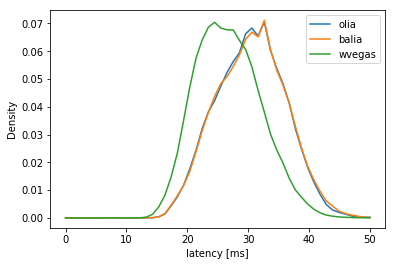

In [5]:
# df_olia['latency [ms]'].max()
p_olia = df_olia['latency [ms]'].plot.kde(ind=np.linspace(0, 50, 50), legend=True)

p_balia = df_balia['latency [ms]'].plot.kde(ind=np.linspace(0, 50, 50), legend=True)

p_wvegas = df_wvegas['latency [ms]'].plot.kde(ind=np.linspace(0, 50, 50), legend=True)
_ = p_wvegas.set_xlabel('latency [ms]')
_ = p_wvegas.legend(['olia', 'balia', 'wvegas'])

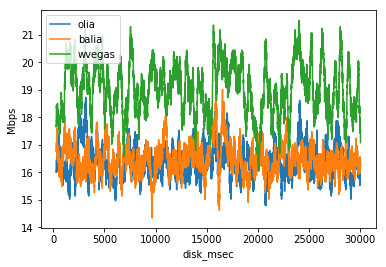

In [52]:
w = 200
# group in 1 msec buckets and sum payloads, effectively calculating goodput in bytes/msec
# * 0.008 since bytes/msec -> Mbps
grouped_o = df_olia.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
grouped_w = df_wvegas.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
grouped_b = df_balia.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
# print(grouped)
grouped_o.rolling(window=w).mean().plot(legend=True)
grouped_b.rolling(window=w).mean().plot(legend=True)
p = grouped_w.rolling(window=w).mean().plot(legend=True)
p.set_ylabel('Mbps')
p.legend(['olia', 'balia', 'wvegas'])

# MPvsSP

In [50]:
topo_indx = 3

df_olia1 = read_flow(file_name.format(congestioncontr[0], topologies[topo_indx], 'snd', 1),
                    file_name.format(congestioncontr[0], topologies[topo_indx], 'rcv', 2))
df_olia2 = read_flow(file_name.format(congestioncontr[0], topologies[topo_indx], 'snd', 3),
                    file_name.format(congestioncontr[0], topologies[topo_indx], 'rcv', 4))

df_balia1 = read_flow(file_name.format(congestioncontr[1], topologies[topo_indx], 'snd', 1),
                     file_name.format(congestioncontr[1], topologies[topo_indx], 'rcv', 2))
df_balia2 = read_flow(file_name.format(congestioncontr[1], topologies[topo_indx], 'snd', 3),
                     file_name.format(congestioncontr[1], topologies[topo_indx], 'rcv', 4))

df_wvegas1 = read_flow(file_name.format(congestioncontr[2], topologies[topo_indx], 'snd', 1),
                      file_name.format(congestioncontr[2], topologies[topo_indx], 'rcv', 2))
df_wvegas2 = read_flow(file_name.format(congestioncontr[2], topologies[topo_indx], 'snd', 3),
                      file_name.format(congestioncontr[2], topologies[topo_indx], 'rcv', 4))

print('Flow')
print('1\tOlia goodput:\t{:.2f}Mbps\tAvg. Latency:\t{:.2f}msec'.format(mean_tp(df_olia1), mean_latency(df_olia1)))
print('2\tOlia goodput:\t{:.2f}Mbps\tAvg. Latency:\t{:.2f}msec'.format(mean_tp(df_olia2), mean_latency(df_olia2)))
print()
print('1\tBalia goodput:\t{:.2f}Mbps\tAvg. Latency:\t{:.2f}msec'.format(mean_tp(df_balia1), mean_latency(df_balia1)))
print('2\tBalia goodput:\t{:.2f}Mbps\tAvg. Latency:\t{:.2f}msec'.format(mean_tp(df_balia2), mean_latency(df_balia2)))
print()
print('1\twVegas goodput:\t{:.2f}Mbps\tAvg. Latency:\t{:.2f}msec'.format(mean_tp(df_wvegas1), mean_latency(df_wvegas1)))
print('2\twVegas goodput:\t{:.2f}Mbps\tAvg. Latency:\t{:.2f}msec'.format(mean_tp(df_wvegas2), mean_latency(df_wvegas2)))

df_olia1['payload [bytes]'].sum() * 8 / 30 / 1000000

# df = df_olia1[(df_olia1['disk_msec'] > 2 * 1000) & (df_olia1['disk_msec'] < 30000 - 2* 1000)]
# df.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
# should count 0 events!!!

Flow
1	Olia goodput:	8.91Mbps	Avg. Latency:	45.98msec
2	Olia goodput:	7.27Mbps	Avg. Latency:	56.99msec

1	Balia goodput:	8.99Mbps	Avg. Latency:	45.69msec
2	Balia goodput:	7.33Mbps	Avg. Latency:	56.51msec

1	wVegas goodput:	9.46Mbps	Avg. Latency:	43.87msec
2	wVegas goodput:	8.01Mbps	Avg. Latency:	51.29msec


8.9152

In [47]:
   
df = tp_array(df_olia1)
df = df[(df['msec'] >= 2000) & (df['msec'] < 28000)]
df
# stats.binned_statistic(df_olia1['disk_msec'], df_olia1['payload [bytes]'], 'sum', bins=range(3000))

,msec,tp [Mbps]
20,2000.0,8.32
21,2100.0,9.60
22,2200.0,8.32
23,2300.0,10.24
24,2400.0,7.68
25,2500.0,9.60
26,2600.0,8.96
27,2700.0,8.32
28,2800.0,8.96
29,2900.0,8.96


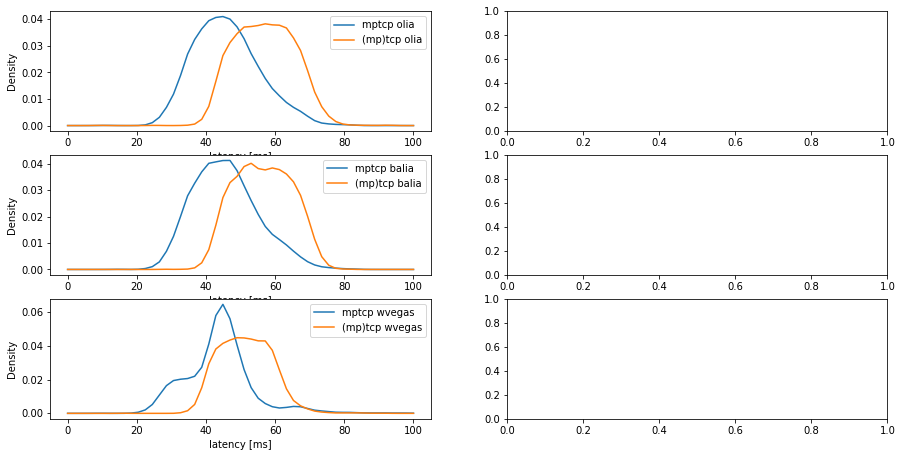

In [8]:
# df_olia['latency [ms]'].max()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 7.5))

p_olia1 = df_olia1['latency [ms]'].plot.kde(ind=np.linspace(0, 100, 50), legend=True, ax=axes[0,0])
p_olia2 = df_olia2['latency [ms]'].plot.kde(ind=np.linspace(0, 100, 50), legend=True, ax=axes[0,0])
_ = p_olia2.set_xlabel('latency [ms]')
_ = p_olia2.legend(['mptcp olia', '(mp)tcp olia'])

p_balia1 = df_balia1['latency [ms]'].plot.kde(ind=np.linspace(0, 100, 50), legend=True, ax=axes[1,0])
p_balia2 = df_balia2['latency [ms]'].plot.kde(ind=np.linspace(0, 100, 50), legend=True, ax=axes[1,0])
_ = p_balia1.set_xlabel('latency [ms]')
_ = p_balia1.legend(['mptcp balia', '(mp)tcp balia'])

p_olia1 = df_wvegas1['latency [ms]'].plot.kde(ind=np.linspace(0, 100, 50), legend=True, ax=axes[2,0])
p_olia2 = df_wvegas2['latency [ms]'].plot.kde(ind=np.linspace(0, 100, 50), legend=True, ax=axes[2,0])
_ = p_olia2.set_xlabel('latency [ms]')
_ = p_olia2.legend(['mptcp wvegas', '(mp)tcp wvegas'])


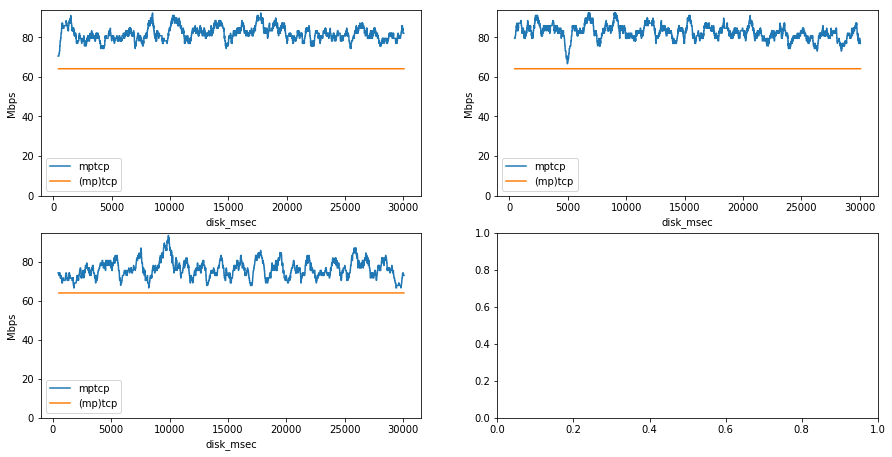

In [9]:
grouped_o1 = df_olia1.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
grouped_o2 = df_olia2.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008

grouped_w1 = df_wvegas1.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
grouped_w2 = df_wvegas2.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008

grouped_b1 = df_balia1.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008
grouped_b2 = df_balia2.groupby(['disk_msec'])['payload [bytes]'].sum() * 0.008

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7.5))
w = 50

# print(grouped)
grouped_o1.rolling(window=w).mean().plot(legend=True, ax=axes[0,0])
p = grouped_o2.rolling(window=w).mean().plot(legend=True, ax=axes[0,0])
p.set_ylabel('Mbps')
p.set_ylim(bottom=0)
p.legend(['mptcp', '(mp)tcp'])

grouped_b1.rolling(window=w).mean().plot(legend=True, ax=axes[0,1])
p = grouped_b2.rolling(window=w).mean().plot(legend=True, ax=axes[0,1])
p.set_ylabel('Mbps')
p.set_ylim(bottom=0)
p.legend(['mptcp', '(mp)tcp'])

grouped_w1.rolling(window=w).mean().plot(legend=True, ax=axes[1,0])
p = grouped_w2.rolling(window=w).mean().plot(legend=True, ax=axes[1,0])
p.set_ylabel('Mbps')
p.set_ylim(bottom=0)
p.legend(['mptcp', '(mp)tcp'])

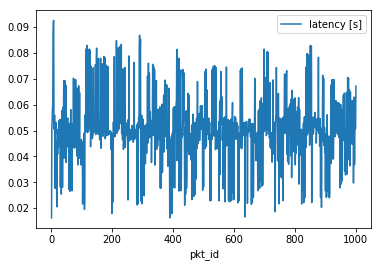

In [46]:
df1[:1000].plot(x=0, y='latency [s]')

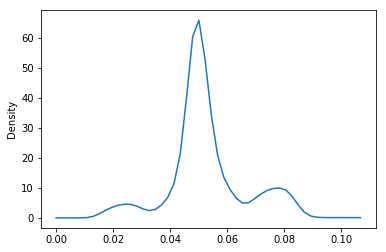

In [93]:
df1['latency [s]'].plot.kde(ind=np.linspace(0, df1['latency [s]'].max()))

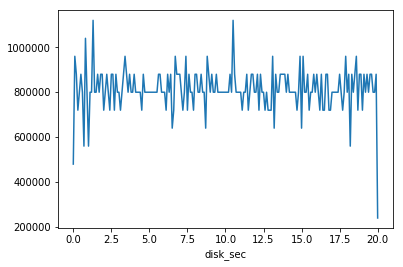

In [86]:
df1['disk_sec'] = df1['sec'].apply(lambda x: np.floor(x * 10) / 10)
# group in 0.1 sec buckets and sum payloads, effectively calculating goodput
(df1.groupby(['disk_sec'])['payload [bytes]'].sum() * 10).plot()